In [1]:
from argparse import ArgumentParser
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
import sys
import pandas as pd
import itertools
from src.modules import * # rename modules to models
from src.train_test import run
from src.utils import *

pd.set_option('display.max_rows', None)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [2]:
parser = ArgumentParser()
config, _ = parser.parse_known_args()

In [3]:
config.model = 'pretraining'
config.output_attentions = True
config.output_hidden_states = True
config.vocab_size = 271 # Time samples
config.hidden_size = 256
config.max_position_embeddings = 20
config.layer_norm_eps = 1e-12
config.hidden_dropout_prob = 0.1
config.num_attention_heads = 4
config.attention_probs_dropout_prob = 0.1
config.intermediate_size = config.hidden_size*4
config.chunk_size_feed_forward = 0
config.num_hidden_layers = 4

config.parent_dir = './results/pretrain/'
config.dataset = './data/pretrain/'
config.batch_size = 256
config.lr = 5e-4
config.epoch = 1000
config.patience = 30

In [4]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

In [5]:
test_data.encodings['inputs_embeds'].shape#[:,:,:]

torch.Size([9000, 20, 271])

In [6]:
idx = torch.randint(len(test_data), (2,)) # accounting for batch

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
mask_label = test_data.encodings['mask_label'][idx]

mask_label[0,:,:]#.shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

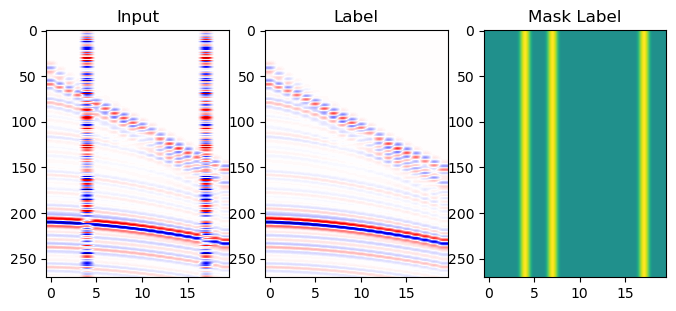

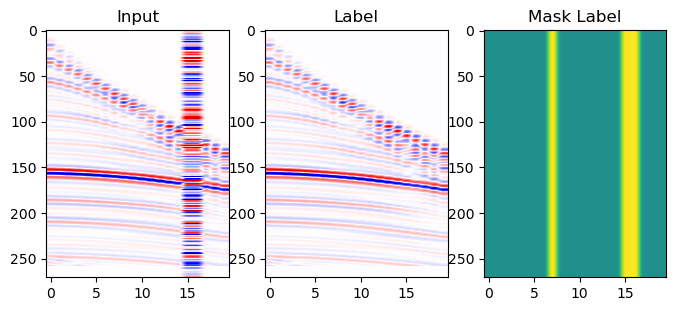

In [7]:
for i in range(len(idx)):
    fig, ax = plt.subplots(1, 3, figsize=(8, 6))
    ax[0].imshow(inputs_embeds[i, :, :].swapaxes(0, 1) - inputs_embeds[i, :, :].mean(), aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
    ax[0].set_title("Input")
    ax[1].imshow(labels[i, :, :].swapaxes(0, 1) - labels[i, :, :].mean(), aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
    ax[1].set_title("Label")
    ax[2].imshow(mask_label[i, :, :].swapaxes(0, 1), aspect=.1, vmin=vmin_all, vmax=vmax_all)
    ax[2].set_title("Mask Label")

In [8]:
train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=config.batch_size, shuffle=True)

In [9]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

In [10]:
model = BertForMaskedLM(config)

In [11]:
from torchinfo import summary

In [12]:
summary(model)

Layer (type:depth-idx)                                       Param #
BertForMaskedLM                                              --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Linear: 3-1                                      69,632
│    │    └─PositionalEncoding: 3-2                          --
│    │    └─LayerNorm: 3-3                                   512
│    │    └─Dropout: 3-4                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-5                                  3,159,040
├─BertOnlyMLMHead: 1-2                                       --
│    └─Linear: 2-3                                           69,647
│    │    └─Identity: 3-6                                    --
Total params: 3,298,831
Trainable params: 3,298,831
Non-trainable params: 0

In [13]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

In [14]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_f

In [15]:
model, avg_train_loss, avg_test_loss, epoch_count = run(model, train_dataloader, test_dataloader, device, config)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.012424 | Average Test Loss: 0.001592  
Validation loss decreased (inf --> 0.001592)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.002614 | Average Test Loss: 0.001427  
Validation loss decreased (0.001592 --> 0.001427)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.002169 | Average Test Loss: 0.001383  
Validation loss decreased (0.001427 --> 0.001383)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001837 | Average Test Loss: 0.001358  
Validation loss decreased (0.001383 --> 0.001358)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001571 | Average Test Loss: 0.001342  
Validation loss decreased (0.001358 --> 0.001342)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001446 | Average Test Loss: 0.001333  
Validation loss decreased (0.001342 --> 0.001333)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001393 | Average Test Loss: 0.001327  
Validation loss decreased (0.001333 --> 0.001327)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001371 | Average Test Loss: 0.001324  
Validation loss decreased (0.001327 --> 0.001324)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001352 | Average Test Loss: 0.001323  
Validation loss decreased (0.001324 --> 0.001323)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001343 | Average Test Loss: 0.001321  
Validation loss decreased (0.001323 --> 0.001321)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001335 | Average Test Loss: 0.001324  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001328 | Average Test Loss: 0.001321  
Validation loss decreased (0.001321 --> 0.001321)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001322 | Average Test Loss: 0.001321  
Validation loss decreased (0.001321 --> 0.001321)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001321 | Average Test Loss: 0.001328  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001315 | Average Test Loss: 0.001321  
Validation loss decreased (0.001321 --> 0.001321)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001313 | Average Test Loss: 0.001321  
Validation loss decreased (0.001321 --> 0.001321)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001312 | Average Test Loss: 0.001323  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001311 | Average Test Loss: 0.001324  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001308 | Average Test Loss: 0.001320  
Validation loss decreased (0.001321 --> 0.001320)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001306 | Average Test Loss: 0.001320  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001306 | Average Test Loss: 0.001317  
Validation loss decreased (0.001320 --> 0.001317)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001304 | Average Test Loss: 0.001325  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001303 | Average Test Loss: 0.001319  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001302 | Average Test Loss: 0.001320  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001302 | Average Test Loss: 0.001318  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001300 | Average Test Loss: 0.001322  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001300 | Average Test Loss: 0.001316  
Validation loss decreased (0.001317 --> 0.001316)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001299 | Average Test Loss: 0.001317  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001298 | Average Test Loss: 0.001316  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001298 | Average Test Loss: 0.001317  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001297 | Average Test Loss: 0.001318  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001296 | Average Test Loss: 0.001318  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001295 | Average Test Loss: 0.001317  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001295 | Average Test Loss: 0.001317  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001295 | Average Test Loss: 0.001316  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001294 | Average Test Loss: 0.001317  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001294 | Average Test Loss: 0.001317  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001294 | Average Test Loss: 0.001315  
Validation loss decreased (0.001316 --> 0.001315)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001294 | Average Test Loss: 0.001315  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001314  
Validation loss decreased (0.001315 --> 0.001314)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001316  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001317  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001320  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001314  
Validation loss decreased (0.001314 --> 0.001314)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001315  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001314  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001316  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001293 | Average Test Loss: 0.001315  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001292 | Average Test Loss: 0.001315  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001292 | Average Test Loss: 0.001314  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001279 | Average Test Loss: 0.001271  
Validation loss decreased (0.001314 --> 0.001271)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001238 | Average Test Loss: 0.001202  
Validation loss decreased (0.001271 --> 0.001202)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001175 | Average Test Loss: 0.001138  
Validation loss decreased (0.001202 --> 0.001138)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.001035 | Average Test Loss: 0.000908  
Validation loss decreased (0.001138 --> 0.000908)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000851 | Average Test Loss: 0.000717  
Validation loss decreased (0.000908 --> 0.000717)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000698 | Average Test Loss: 0.000603  
Validation loss decreased (0.000717 --> 0.000603)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000611 | Average Test Loss: 0.000537  
Validation loss decreased (0.000603 --> 0.000537)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000558 | Average Test Loss: 0.000492  
Validation loss decreased (0.000537 --> 0.000492)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000520 | Average Test Loss: 0.000463  
Validation loss decreased (0.000492 --> 0.000463)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000490 | Average Test Loss: 0.000437  
Validation loss decreased (0.000463 --> 0.000437)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000465 | Average Test Loss: 0.000410  
Validation loss decreased (0.000437 --> 0.000410)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000443 | Average Test Loss: 0.000393  
Validation loss decreased (0.000410 --> 0.000393)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000424 | Average Test Loss: 0.000372  
Validation loss decreased (0.000393 --> 0.000372)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000406 | Average Test Loss: 0.000359  
Validation loss decreased (0.000372 --> 0.000359)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000391 | Average Test Loss: 0.000338  
Validation loss decreased (0.000359 --> 0.000338)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000376 | Average Test Loss: 0.000325  
Validation loss decreased (0.000338 --> 0.000325)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000360 | Average Test Loss: 0.000307  
Validation loss decreased (0.000325 --> 0.000307)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000346 | Average Test Loss: 0.000295  
Validation loss decreased (0.000307 --> 0.000295)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000332 | Average Test Loss: 0.000278  
Validation loss decreased (0.000295 --> 0.000278)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000319 | Average Test Loss: 0.000267  
Validation loss decreased (0.000278 --> 0.000267)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000306 | Average Test Loss: 0.000255  
Validation loss decreased (0.000267 --> 0.000255)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000295 | Average Test Loss: 0.000241  
Validation loss decreased (0.000255 --> 0.000241)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000285 | Average Test Loss: 0.000234  
Validation loss decreased (0.000241 --> 0.000234)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000276 | Average Test Loss: 0.000225  
Validation loss decreased (0.000234 --> 0.000225)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000267 | Average Test Loss: 0.000220  
Validation loss decreased (0.000225 --> 0.000220)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000259 | Average Test Loss: 0.000209  
Validation loss decreased (0.000220 --> 0.000209)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000252 | Average Test Loss: 0.000201  
Validation loss decreased (0.000209 --> 0.000201)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000244 | Average Test Loss: 0.000195  
Validation loss decreased (0.000201 --> 0.000195)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000238 | Average Test Loss: 0.000195  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000231 | Average Test Loss: 0.000181  
Validation loss decreased (0.000195 --> 0.000181)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000226 | Average Test Loss: 0.000181  
Validation loss decreased (0.000181 --> 0.000181)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000219 | Average Test Loss: 0.000172  
Validation loss decreased (0.000181 --> 0.000172)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000212 | Average Test Loss: 0.000170  
Validation loss decreased (0.000172 --> 0.000170)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000208 | Average Test Loss: 0.000160  
Validation loss decreased (0.000170 --> 0.000160)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000203 | Average Test Loss: 0.000156  
Validation loss decreased (0.000160 --> 0.000156)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000199 | Average Test Loss: 0.000152  
Validation loss decreased (0.000156 --> 0.000152)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000194 | Average Test Loss: 0.000149  
Validation loss decreased (0.000152 --> 0.000149)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000190 | Average Test Loss: 0.000144  
Validation loss decreased (0.000149 --> 0.000144)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000185 | Average Test Loss: 0.000141  
Validation loss decreased (0.000144 --> 0.000141)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000182 | Average Test Loss: 0.000137  
Validation loss decreased (0.000141 --> 0.000137)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000177 | Average Test Loss: 0.000134  
Validation loss decreased (0.000137 --> 0.000134)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000175 | Average Test Loss: 0.000131  
Validation loss decreased (0.000134 --> 0.000131)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000171 | Average Test Loss: 0.000128  
Validation loss decreased (0.000131 --> 0.000128)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000167 | Average Test Loss: 0.000126  
Validation loss decreased (0.000128 --> 0.000126)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000164 | Average Test Loss: 0.000123  
Validation loss decreased (0.000126 --> 0.000123)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000161 | Average Test Loss: 0.000119  
Validation loss decreased (0.000123 --> 0.000119)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000159 | Average Test Loss: 0.000118  
Validation loss decreased (0.000119 --> 0.000118)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000156 | Average Test Loss: 0.000115  
Validation loss decreased (0.000118 --> 0.000115)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000154 | Average Test Loss: 0.000115  
Validation loss decreased (0.000115 --> 0.000115)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000152 | Average Test Loss: 0.000113  
Validation loss decreased (0.000115 --> 0.000113)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000149 | Average Test Loss: 0.000110  
Validation loss decreased (0.000113 --> 0.000110)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000147 | Average Test Loss: 0.000110  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000144 | Average Test Loss: 0.000107  
Validation loss decreased (0.000110 --> 0.000107)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000143 | Average Test Loss: 0.000109  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000141 | Average Test Loss: 0.000104  
Validation loss decreased (0.000107 --> 0.000104)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000139 | Average Test Loss: 0.000104  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000138 | Average Test Loss: 0.000103  
Validation loss decreased (0.000104 --> 0.000103)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000136 | Average Test Loss: 0.000102  
Validation loss decreased (0.000103 --> 0.000102)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000135 | Average Test Loss: 0.000100  
Validation loss decreased (0.000102 --> 0.000100)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000132 | Average Test Loss: 0.000099  
Validation loss decreased (0.000100 --> 0.000099)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000132 | Average Test Loss: 0.000098  
Validation loss decreased (0.000099 --> 0.000098)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000130 | Average Test Loss: 0.000096  
Validation loss decreased (0.000098 --> 0.000096)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000129 | Average Test Loss: 0.000096  
Validation loss decreased (0.000096 --> 0.000096)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000127 | Average Test Loss: 0.000094  
Validation loss decreased (0.000096 --> 0.000094)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000126 | Average Test Loss: 0.000094  
Validation loss decreased (0.000094 --> 0.000094)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000124 | Average Test Loss: 0.000092  
Validation loss decreased (0.000094 --> 0.000092)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000123 | Average Test Loss: 0.000092  
Validation loss decreased (0.000092 --> 0.000092)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000123 | Average Test Loss: 0.000091  
Validation loss decreased (0.000092 --> 0.000091)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000121 | Average Test Loss: 0.000090  
Validation loss decreased (0.000091 --> 0.000090)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000120 | Average Test Loss: 0.000090  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000119 | Average Test Loss: 0.000089  
Validation loss decreased (0.000090 --> 0.000089)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000118 | Average Test Loss: 0.000088  
Validation loss decreased (0.000089 --> 0.000088)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000118 | Average Test Loss: 0.000088  
Validation loss decreased (0.000088 --> 0.000088)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000116 | Average Test Loss: 0.000088  
Validation loss decreased (0.000088 --> 0.000088)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000115 | Average Test Loss: 0.000087  
Validation loss decreased (0.000088 --> 0.000087)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000115 | Average Test Loss: 0.000086  
Validation loss decreased (0.000087 --> 0.000086)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000113 | Average Test Loss: 0.000086  
Validation loss decreased (0.000086 --> 0.000086)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000113 | Average Test Loss: 0.000084  
Validation loss decreased (0.000086 --> 0.000084)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000112 | Average Test Loss: 0.000083  
Validation loss decreased (0.000084 --> 0.000083)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000111 | Average Test Loss: 0.000083  
Validation loss decreased (0.000083 --> 0.000083)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000110 | Average Test Loss: 0.000082  
Validation loss decreased (0.000083 --> 0.000082)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000109 | Average Test Loss: 0.000082  
Validation loss decreased (0.000082 --> 0.000082)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000109 | Average Test Loss: 0.000081  
Validation loss decreased (0.000082 --> 0.000081)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000108 | Average Test Loss: 0.000081  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000107 | Average Test Loss: 0.000080  
Validation loss decreased (0.000081 --> 0.000080)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000107 | Average Test Loss: 0.000080  
Validation loss decreased (0.000080 --> 0.000080)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000106 | Average Test Loss: 0.000081  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000105 | Average Test Loss: 0.000080  
Validation loss decreased (0.000080 --> 0.000080)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000105 | Average Test Loss: 0.000079  
Validation loss decreased (0.000080 --> 0.000079)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000103 | Average Test Loss: 0.000079  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000103 | Average Test Loss: 0.000078  
Validation loss decreased (0.000079 --> 0.000078)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000103 | Average Test Loss: 0.000076  
Validation loss decreased (0.000078 --> 0.000076)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000102 | Average Test Loss: 0.000076  
Validation loss decreased (0.000076 --> 0.000076)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000101 | Average Test Loss: 0.000076  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000101 | Average Test Loss: 0.000077  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000100 | Average Test Loss: 0.000076  
Validation loss decreased (0.000076 --> 0.000076)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000099 | Average Test Loss: 0.000075  
Validation loss decreased (0.000076 --> 0.000075)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000099 | Average Test Loss: 0.000075  
Validation loss decreased (0.000075 --> 0.000075)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000099 | Average Test Loss: 0.000074  
Validation loss decreased (0.000075 --> 0.000074)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000098 | Average Test Loss: 0.000074  
Validation loss decreased (0.000074 --> 0.000074)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000098 | Average Test Loss: 0.000074  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000097 | Average Test Loss: 0.000073  
Validation loss decreased (0.000074 --> 0.000073)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000097 | Average Test Loss: 0.000073  
Validation loss decreased (0.000073 --> 0.000073)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000096 | Average Test Loss: 0.000073  
Validation loss decreased (0.000073 --> 0.000073)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000096 | Average Test Loss: 0.000072  
Validation loss decreased (0.000073 --> 0.000072)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000095 | Average Test Loss: 0.000073  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000095 | Average Test Loss: 0.000072  
Validation loss decreased (0.000072 --> 0.000072)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000094 | Average Test Loss: 0.000071  
Validation loss decreased (0.000072 --> 0.000071)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000094 | Average Test Loss: 0.000071  
Validation loss decreased (0.000071 --> 0.000071)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000093 | Average Test Loss: 0.000071  
Validation loss decreased (0.000071 --> 0.000071)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000093 | Average Test Loss: 0.000071  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000092 | Average Test Loss: 0.000071  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000092 | Average Test Loss: 0.000071  
Validation loss decreased (0.000071 --> 0.000071)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000091 | Average Test Loss: 0.000070  
Validation loss decreased (0.000071 --> 0.000070)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000091 | Average Test Loss: 0.000070  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000091 | Average Test Loss: 0.000069  
Validation loss decreased (0.000070 --> 0.000069)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000090 | Average Test Loss: 0.000069  
Validation loss decreased (0.000069 --> 0.000069)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000090 | Average Test Loss: 0.000068  
Validation loss decreased (0.000069 --> 0.000068)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000089 | Average Test Loss: 0.000068  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000089 | Average Test Loss: 0.000067  
Validation loss decreased (0.000068 --> 0.000067)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000090 | Average Test Loss: 0.000069  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000089 | Average Test Loss: 0.000068  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000088 | Average Test Loss: 0.000068  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000088 | Average Test Loss: 0.000067  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000088 | Average Test Loss: 0.000066  
Validation loss decreased (0.000067 --> 0.000066)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000087 | Average Test Loss: 0.000067  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000087 | Average Test Loss: 0.000066  
Validation loss decreased (0.000066 --> 0.000066)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000087 | Average Test Loss: 0.000066  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000086 | Average Test Loss: 0.000067  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000086 | Average Test Loss: 0.000066  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000085 | Average Test Loss: 0.000066  
Validation loss decreased (0.000066 --> 0.000066)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000085 | Average Test Loss: 0.000066  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000085 | Average Test Loss: 0.000065  
Validation loss decreased (0.000066 --> 0.000065)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000085 | Average Test Loss: 0.000065  
Validation loss decreased (0.000065 --> 0.000065)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000084 | Average Test Loss: 0.000065  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000084 | Average Test Loss: 0.000064  
Validation loss decreased (0.000065 --> 0.000064)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000083 | Average Test Loss: 0.000065  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000083 | Average Test Loss: 0.000064  
Validation loss decreased (0.000064 --> 0.000064)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000083 | Average Test Loss: 0.000064  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000083 | Average Test Loss: 0.000064  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000083 | Average Test Loss: 0.000064  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000082 | Average Test Loss: 0.000063  
Validation loss decreased (0.000064 --> 0.000063)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000082 | Average Test Loss: 0.000063  
Validation loss decreased (0.000063 --> 0.000063)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000082 | Average Test Loss: 0.000064  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000081 | Average Test Loss: 0.000063  
Validation loss decreased (0.000063 --> 0.000063)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000081 | Average Test Loss: 0.000063  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000081 | Average Test Loss: 0.000063  
Validation loss decreased (0.000063 --> 0.000063)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000080 | Average Test Loss: 0.000063  
Validation loss decreased (0.000063 --> 0.000063)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000080 | Average Test Loss: 0.000063  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000080 | Average Test Loss: 0.000062  
Validation loss decreased (0.000063 --> 0.000062)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000079 | Average Test Loss: 0.000062  
Validation loss decreased (0.000062 --> 0.000062)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000080 | Average Test Loss: 0.000062  
Validation loss decreased (0.000062 --> 0.000062)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000079 | Average Test Loss: 0.000062  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000079 | Average Test Loss: 0.000063  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000079 | Average Test Loss: 0.000061  
Validation loss decreased (0.000062 --> 0.000061)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000078 | Average Test Loss: 0.000062  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000078 | Average Test Loss: 0.000062  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000079 | Average Test Loss: 0.000062  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000078 | Average Test Loss: 0.000061  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000078 | Average Test Loss: 0.000061  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000061  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000060  
Validation loss decreased (0.000061 --> 0.000060)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000061  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000061  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000076 | Average Test Loss: 0.000060  
Validation loss decreased (0.000060 --> 0.000060)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000061  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000077 | Average Test Loss: 0.000059  
Validation loss decreased (0.000060 --> 0.000059)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000076 | Average Test Loss: 0.000060  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000076 | Average Test Loss: 0.000060  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000076 | Average Test Loss: 0.000059  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000075 | Average Test Loss: 0.000059  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000075 | Average Test Loss: 0.000060  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000075 | Average Test Loss: 0.000059  
Validation loss decreased (0.000059 --> 0.000059)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000075 | Average Test Loss: 0.000059  
Validation loss decreased (0.000059 --> 0.000059)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000060  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000058  
Validation loss decreased (0.000059 --> 0.000058)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000059  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000058  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000058  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000074 | Average Test Loss: 0.000058  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000073 | Average Test Loss: 0.000059  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000073 | Average Test Loss: 0.000058  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000073 | Average Test Loss: 0.000058  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000072 | Average Test Loss: 0.000058  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000073 | Average Test Loss: 0.000058  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000073 | Average Test Loss: 0.000057  
Validation loss decreased (0.000058 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000072 | Average Test Loss: 0.000058  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000072 | Average Test Loss: 0.000058  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000072 | Average Test Loss: 0.000057  
Validation loss decreased (0.000057 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000072 | Average Test Loss: 0.000057  
Validation loss decreased (0.000057 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
Validation loss decreased (0.000057 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
Validation loss decreased (0.000057 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
Validation loss decreased (0.000057 --> 0.000057)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000056  
Validation loss decreased (0.000057 --> 0.000056)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000057  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000056  
Validation loss decreased (0.000056 --> 0.000056)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000071 | Average Test Loss: 0.000056  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000070 | Average Test Loss: 0.000057  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000070 | Average Test Loss: 0.000057  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000070 | Average Test Loss: 0.000056  
Validation loss decreased (0.000056 --> 0.000056)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000070 | Average Test Loss: 0.000057  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000070 | Average Test Loss: 0.000056  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
Validation loss decreased (0.000056 --> 0.000055)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000056  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000056  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
Validation loss decreased (0.000055 --> 0.000055)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
Validation loss decreased (0.000055 --> 0.000055)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
Validation loss decreased (0.000055 --> 0.000055)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000069 | Average Test Loss: 0.000055  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000068 | Average Test Loss: 0.000054  
Validation loss decreased (0.000055 --> 0.000054)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000068 | Average Test Loss: 0.000056  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000068 | Average Test Loss: 0.000055  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000068 | Average Test Loss: 0.000055  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000054  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000068 | Average Test Loss: 0.000055  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000055  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000055  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000055  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000054  
Validation loss decreased (0.000054 --> 0.000054)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000054  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000054  
Validation loss decreased (0.000054 --> 0.000054)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000055  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000067 | Average Test Loss: 0.000054  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
Validation loss decreased (0.000054 --> 0.000054)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000066 | Average Test Loss: 0.000054  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000054  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000053  
Validation loss decreased (0.000054 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000053  
Validation loss decreased (0.000053 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000053  
Validation loss decreased (0.000053 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000054  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000054  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000053  
Validation loss decreased (0.000053 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000065 | Average Test Loss: 0.000053  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
Validation loss decreased (0.000053 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
Validation loss decreased (0.000053 --> 0.000053)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000064 | Average Test Loss: 0.000053  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
Validation loss decreased (0.000053 --> 0.000052)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000053  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000053  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000053  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
Validation loss decreased (0.000052 --> 0.000052)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000053  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000063 | Average Test Loss: 0.000052  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000052  
Validation loss decreased (0.000052 --> 0.000052)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000052  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000052  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000052  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000051  
Validation loss decreased (0.000052 --> 0.000051)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000051  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000051  
Validation loss decreased (0.000051 --> 0.000051)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000051  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000051  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000062 | Average Test Loss: 0.000052  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
Validation loss decreased (0.000051 --> 0.000051)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
Validation loss decreased (0.000051 --> 0.000051)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000052  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000052  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000050  
Validation loss decreased (0.000051 --> 0.000050)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000052  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000052  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000061 | Average Test Loss: 0.000051  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
Validation loss decreased (0.000050 --> 0.000050)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
Validation loss decreased (0.000050 --> 0.000050)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
Validation loss decreased (0.000050 --> 0.000050)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000051  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000060 | Average Test Loss: 0.000050  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
Validation loss decreased (0.000050 --> 0.000050)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000049  
Validation loss decreased (0.000050 --> 0.000049)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000049  
Validation loss decreased (0.000049 --> 0.000049)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000050  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000049  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000050  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000050  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000050  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000059 | Average Test Loss: 0.000050  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
Validation loss decreased (0.000049 --> 0.000049)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
Validation loss decreased (0.000049 --> 0.000049)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
Validation loss decreased (0.000049 --> 0.000049)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000049  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000058 | Average Test Loss: 0.000048  
Validation loss decreased (0.000049 --> 0.000048)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
Validation loss decreased (0.000048 --> 0.000048)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
Validation loss decreased (0.000048 --> 0.000048)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000049  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000057 | Average Test Loss: 0.000048  
Validation loss decreased (0.000048 --> 0.000048)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000049  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000047  
Validation loss decreased (0.000048 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000049  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000049  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000047  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000048  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000056 | Average Test Loss: 0.000047  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000048  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000048  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
Validation loss decreased (0.000047 --> 0.000047)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000055 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
Validation loss decreased (0.000047 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000047  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000054 | Average Test Loss: 0.000046  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
Validation loss decreased (0.000046 --> 0.000046)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000045  
Validation loss decreased (0.000046 --> 0.000045)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
Validation loss decreased (0.000045 --> 0.000045)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000047  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000045  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
Validation loss decreased (0.000045 --> 0.000045)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
Validation loss decreased (0.000045 --> 0.000045)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
Validation loss decreased (0.000045 --> 0.000045)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000046  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000053 | Average Test Loss: 0.000046  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000052 | Average Test Loss: 0.000045  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000046  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000046  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
Validation loss decreased (0.000045 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
Validation loss decreased (0.000044 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
Validation loss decreased (0.000044 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000046  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
Validation loss decreased (0.000044 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
Validation loss decreased (0.000044 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000045  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000044  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000045  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
Validation loss decreased (0.000044 --> 0.000044)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000051 | Average Test Loss: 0.000045  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000043  
Validation loss decreased (0.000044 --> 0.000043)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000043  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000043  
Validation loss decreased (0.000043 --> 0.000043)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000050 | Average Test Loss: 0.000044  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 19 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 20 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
Validation loss decreased (0.000043 --> 0.000043)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
Validation loss decreased (0.000043 --> 0.000043)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
Validation loss decreased (0.000043 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000049 | Average Test Loss: 0.000043  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000044  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000044  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000043  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
Validation loss decreased (0.000042 --> 0.000042)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000048 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000041  
Validation loss decreased (0.000042 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000041  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000042  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000042  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000047 | Average Test Loss: 0.000041  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
Validation loss decreased (0.000041 --> 0.000041)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000040  
Validation loss decreased (0.000041 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000042  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000041  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000046 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
Validation loss decreased (0.000040 --> 0.000040)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 19 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000041  
EarlyStopping counter: 20 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 21 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 22 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 23 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 24 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 25 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000041  
EarlyStopping counter: 26 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 27 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 28 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
Validation loss decreased (0.000040 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000041  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000041  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 18 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000045 | Average Test Loss: 0.000040  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000040  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000040  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000040  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000040  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000044 | Average Test Loss: 0.000039  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000040  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 14 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 15 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 16 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 17 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
Validation loss decreased (0.000039 --> 0.000039)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
Validation loss decreased (0.000039 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
Validation loss decreased (0.000038 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
Validation loss decreased (0.000038 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
Validation loss decreased (0.000038 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000038  
Validation loss decreased (0.000038 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
Validation loss decreased (0.000038 --> 0.000038)
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 1 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 2 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 3 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 4 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 5 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 6 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000039  
EarlyStopping counter: 7 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 8 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 9 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000043 | Average Test Loss: 0.000039  
EarlyStopping counter: 10 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 11 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 12 out of 30
----------------------------------------------------------------------------------------


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Average Train Loss: 0.000042 | Average Test Loss: 0.000038  
EarlyStopping counter: 13 out of 30
----------------------------------------------------------------------------------------


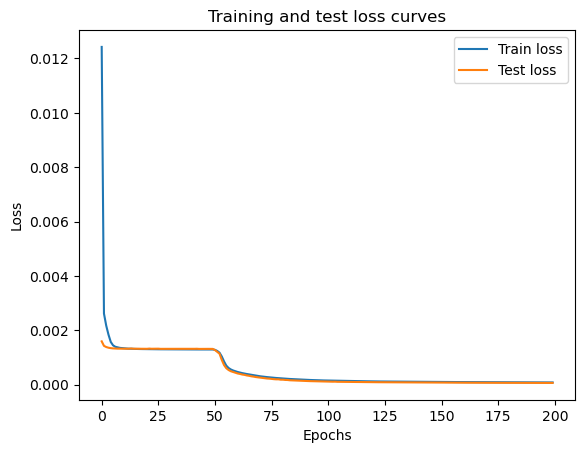

In [30]:
def plot_loss(epoch_count, train_loss, test_loss):
    # Plot Test and Train Loss
    plt.plot(epoch_count[:200], train_loss[:200], label="Train loss")
    plt.plot(epoch_count[:200], test_loss[:200], label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    #plt.savefig('loss.png');

plot_loss(epoch_count, avg_train_loss, avg_test_loss)

tensor([4697, 3447])


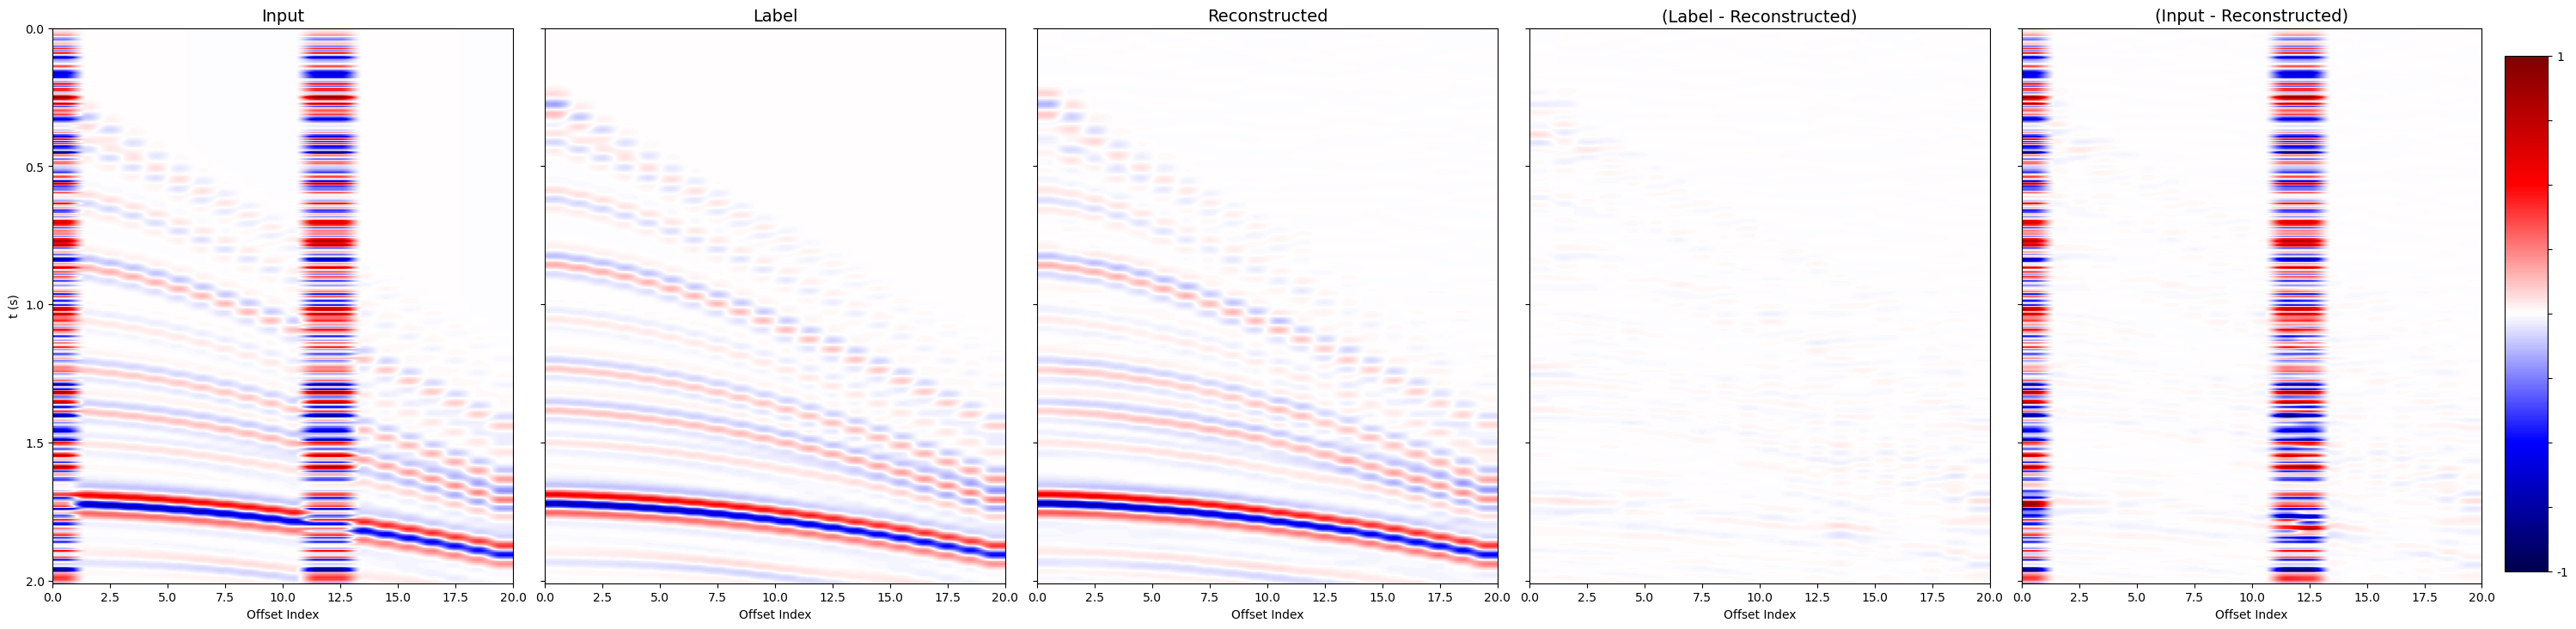

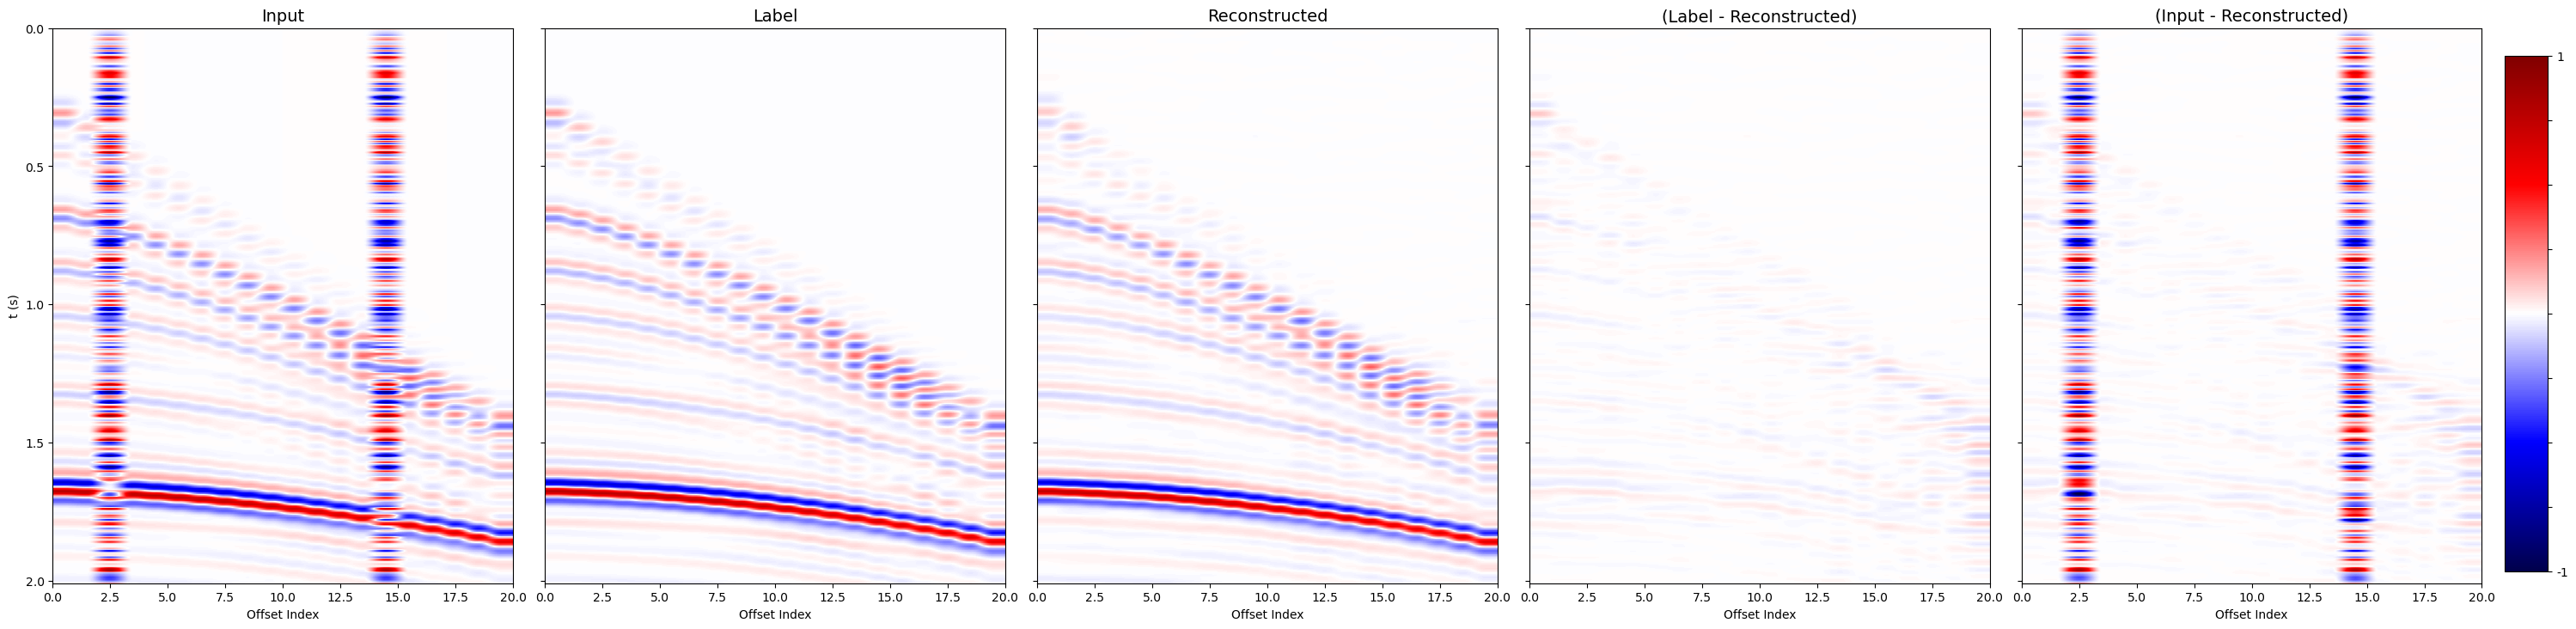

In [27]:
model.eval()

idx = torch.randint(len(test_data), (2,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
mask_label = test_data.encodings['mask_label'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    fig, ax = plt.subplots(1, 5, figsize=(29, 7.5), sharey=True, sharex=False)
    fig.tight_layout()
    ax[0].imshow(X.detach().swapaxes(0, 1) - X.mean(dim=1), aspect=12, vmin=-1, vmax=1, cmap='seismic', extent=[0, 20, 271*8/1000, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].set_xlabel("Offset Index")
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].set_ylabel("t (s)")
    ax[1].imshow(z.detach().swapaxes(0, 1) - z.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic', extent=[0, 20, 271*8/1000, 0])
    ax[1].set_title("Label", fontsize=14)
    ax[1].set_xlabel("Offset Index")
    output = y
    ax[2].imshow(output.detach().swapaxes(0, 1) - output.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic', extent=[0, 20, 271*8/1000, 0])
    ax[2].set_title("Reconstructed", fontsize=14)
    ax[2].set_xlabel("Offset Index")
    diff = (z - output)
    im4 = ax[3].imshow(diff.detach().swapaxes(0, 1), aspect=12, vmin=-1, vmax=1, cmap='seismic', extent=[0, 20, 271*8/1000, 0])
    ax[3].set_title("(Label - Reconstructed)", fontsize=14)
    ax[3].set_xlabel("Offset Index")
    diff2 = (X - output)
    ax[4].imshow(diff2.detach().swapaxes(0, 1), aspect=12, vmin=-1, vmax=1, cmap='seismic', extent=[0, 20, 271*8/1000, 0])
    ax[4].set_title("(Input - Reconstructed)", fontsize=14)
    ax[4].set_xlabel("Offset Index")
    plt.ylim(2.01, 0)
        
    cbar_ax = fig.add_axes([1, 0.1, 0.0175, 0.8])
    cbar = fig.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

In [28]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_test_loss_arr = np.array(avg_test_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_test_loss_arr = np.array(avg_test_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'test_loss.npy'), avg_test_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/pretrain/
Saved successfully to ./results/pretrain/


In [ ]:
#youtube videos on shot gathers
#https://www.youtube.com/watch?v=CCFMZV2zuN8&ab_channel=Tom%27sGeophysics
#https://www.youtube.com/watch?v=uFL4YOZEMeE&ab_channel=RobButler